# Chapter 4 — Training Models (Revision Notebook)

**Goal:** compact theory + runnable snippets. Use this as a quick revision: all important concepts are explained in short markdown blocks and demonstrated with small code examples or plots.

Files: this notebook contains markdown theory sections and code cells. Run cells in order to reproduce the plots and examples.

---

## 1 — Linear Regression

**Idea:** predict a continuous target as a weighted sum of input features.

**Model (scalar):**
```
ŷ = θ₀ + θ₁ x₁ + θ₂ x₂ + ... + θ_n x_n
```

**Vector form:**
```
ŷ = θᵀ x
```

**Goal:** find parameter vector θ that minimizes a loss (commonly MSE).

### 1.1 Normal Equation (closed-form)

Solves for θ that minimizes the Mean Squared Error (no iterations):

```
θ = (Xᵀ X)⁻¹ Xᵀ y
```

**Notes:** fast for small feature count; expensive or unstable when XᵀX is singular or when n is large. Use regularization or iterative methods in that case.

In [1]:
# Normal Equation example (synthetic data)
import numpy as np

# synthetic simple linear data
rng = np.random.default_rng(0)
X = rng.random((100,1)) * 10
y = 2.5 + 1.7 * X[:,0] + rng.normal(0, 1.0, size=100)

# add bias column
X_b = np.c_[np.ones((X.shape[0],1)), X]
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best


array([2.49254002, 1.6869275 ])

### 1.2 When to use Normal Equation vs Gradient Descent

- **Normal Equation**: small number of features, exact solution.
- **Gradient Descent (GD)**: large datasets/features, iterative control of computation and memory.


## 2 — Gradient Descent (GD)

**Idea:** iteratively update parameters to reduce loss. General update:

```
θ := θ − η ∇J(θ)
```

η = learning rate. Choose carefully (too large → diverge; too small → slow).

Variants:
- **Batch GD:** gradient computed over whole training set each step. Stable but slow.
- **Stochastic GD (SGD):** update using one training example at a time. Fast and noisy.
- **Mini-batch GD:** update using small batches (common default).


In [2]:
# Simple gradient descent for linear regression (1 feature)
import numpy as np

def gradient_descent(X_b, y, lr=0.01, n_iters=1000):
    m = len(y)
    theta = np.zeros(X_b.shape[1])
    history = []
    for i in range(n_iters):
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta = theta - lr * gradients
        history.append(theta.copy())
    return theta, np.array(history)

# reuse X_b, y from previous cell
theta_gd, hist = gradient_descent(X_b, y, lr=0.01, n_iters=1000)
theta_gd


array([2.47034632, 1.69004609])

### Practical tips for GD
- Feature scaling (standardize) speeds convergence.
- Use learning rate schedules or adaptive optimizers (momentum, Adam) for deep nets.
- Monitor training and validation loss to detect overfitting and divergence.


## 3 — Polynomial Regression

**Idea:** map input features to polynomial features (x, x², x³, ...) then use linear model.

**Pros:** can model non-linear relationships with a linear algorithm.
**Cons:** increases feature count, prone to overfitting.


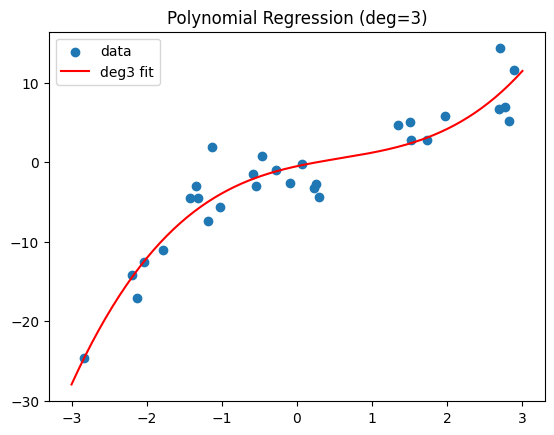

In [3]:
# Polynomial regression example (plot)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

rng = np.random.default_rng(1)
X = rng.random((30,1)) * 6 - 3
y = 0.5 * X[:,0]**3 - X[:,0]**2 + 2*X[:,0] + rng.normal(0, 3, size=30)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
lin = LinearRegression().fit(X_poly, y)

X_new = np.linspace(-3,3,200).reshape(200,1)
y_pred = lin.predict(poly.transform(X_new))

plt.scatter(X, y, label='data')
plt.plot(X_new, y_pred, 'r-', label='deg3 fit')
plt.legend()
plt.title('Polynomial Regression (deg=3)')
plt.show()


## 4 — Learning Curves

Plot **training error** vs **validation error** as function of training set size or epochs. Use them to diagnose:

- **High bias:** both training & validation errors are high and close.
- **High variance:** training error low, validation error high.

**Remedies:**
- High bias → increase model complexity, add features, reduce regularization.
- High variance → more training data, regularization, simpler model.


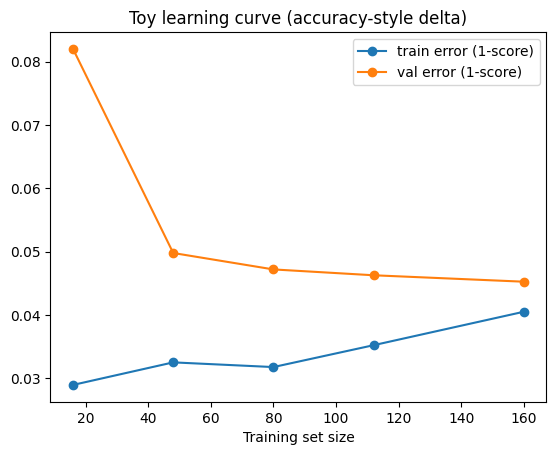

In [4]:
# Toy learning curve example (using sklearn learning_curve)
from sklearn.model_selection import learning_curve
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=200, n_features=5, noise=20, random_state=42)
pipe = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
train_sizes, train_scores, val_scores = learning_curve(pipe, X, y, cv=5, train_sizes=[0.1,0.3,0.5,0.7,1.0])

train_err = 1 - np.mean(train_scores, axis=1)
val_err = 1 - np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_err, 'o-', label='train error (1-score)')
plt.plot(train_sizes, val_err, 'o-', label='val error (1-score)')
plt.xlabel('Training set size')
plt.legend()
plt.title('Toy learning curve (accuracy-style delta)')
plt.show()


## 5 — Regularization (reduce overfitting)

Add penalty to loss to discourage large weights.

- **Ridge (L2):** adds α Σ θ_j². Shrinks weights but keeps them non-zero.
- **Lasso (L1):** adds α Σ |θ_j|. Can set some weights to zero → feature selection.
- **Elastic Net:** combination of L1 and L2.

**Use-case:** when model overfits (train error low, val error high) or when multicollinearity is present.


In [5]:
# Regularized regression quick example
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = make_regression(n_samples=200, n_features=30, noise=15, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

ridge = Ridge(alpha=1.0).fit(X_train, y_train)
lasso = Lasso(alpha=0.5, max_iter=10000).fit(X_train, y_train)
enet = ElasticNet(alpha=0.5, l1_ratio=0.5, max_iter=10000).fit(X_train, y_train)

print('Ridge RMSE:', np.sqrt(mean_squared_error(y_test, ridge.predict(X_test))))
print('Lasso RMSE:', np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))
print('ElasticNet RMSE:', np.sqrt(mean_squared_error(y_test, enet.predict(X_test))))


Ridge RMSE: 13.794653741727979
Lasso RMSE: 13.343977430117363
ElasticNet RMSE: 40.39390956287851


### Early Stopping
Stop training when validation performance stops improving. Practical for iterative algorithms (SGD, neural nets).

## 6 — Logistic Regression (binary classification)

**Goal:** estimate probability of class 1.

**Model:** z = θᵀ x, then apply sigmoid:
```
p = σ(z) = 1 / (1 + e^{-z})
```
Decision threshold commonly 0.5.

**Loss:** cross-entropy (log loss):
```
J(θ) = -1/m Σ [ y log p + (1-y) log(1-p) ]
```

Logistic regression can be regularized (L1/L2).


In [6]:
# Logistic regression demo (Iris: binary case)
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

iris = load_iris()
# make it binary: 'is setosa' vs others
X = iris.data[iris.target != 2]
y = (iris.target[iris.target != 2] == 1).astype(int)  # 1 vs 0
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## 7 — Softmax Regression (multiclass)

For K classes, compute scores s_k = θ_kᵀ x for each class k, then softmax gives probabilities:

```
P(y=k|x) = exp(s_k) / Σ_j exp(s_j)
```

Prediction is argmax of the scores or probabilities.

Softmax uses cross-entropy loss generalized to multiple classes.


In [ ]:
# Softmax (multinomial logistic) with sklearn on Iris (3 classes)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

iris = load_iris()
X, y = iris.data, iris.target
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200).fit(X, y)
print('Accuracy (Iris):', accuracy_score(y, clf.predict(X)))


## 8 — Cost functions & gradients (short)

- **Linear regression (MSE):** J(θ) = (1/2m) Σ (ŷ - y)². Gradient: (1/m) Xᵀ(Xθ - y)
- **Logistic regression (binary cross-entropy):** J(θ) = -1/m Σ [ y log p + (1−y) log(1−p) ]
- **Softmax + cross-entropy:** gradient for class k: (1/m) Σ (p_k^i - y_k^i) x^i

Gradients are used by GD to update parameters.


## 9 — Quick reference (one-glance)

- **Normal Equation:** closed-form, use when features small.
- **GD (Batch/SGD/Mini-batch):** iterative, use for large problems.
- **Polynomial features:** allow non-linear fits; beware overfitting.
- **Ridge/Lasso/ElasticNet:** regularization to reduce overfitting.
- **Logistic:** binary classification with sigmoid + cross-entropy.
- **Softmax:** multiclass generalization of logistic.

---

*End of notebook — edit, run, and extend plots or code as needed.*